# Bayesian signal reconstruction with Gaussian Random Fields (Wiener Filtering) - CMB example

Florent Leclercq,<br/>
Institut d'Astrophysique de Paris,<br/>
florent.leclercq@iap.fr

This notebook requires healpy (https://healpy.readthedocs.io/en/latest/), the CLASS code (https://class-code.net) and its python wrapper classy, as well as the Planck colormap (https://raw.githubusercontent.com/zonca/paperplots/master/data/Planck_Parchment_RGB.txt).
Optionally, pre-computed data are available:<br/>
* https://cloud.aquila-consortium.org/s/WienerFilter_denoising_CMB_1/download/sqrtsignalcovarPix.npy (2.4 GB)
* https://cloud.aquila-consortium.org/s/WienerFilter_denoising_CMB_2/download/sqrtCovWF.npy (2.4 GB)
* https://cloud.aquila-consortium.org/s/WienerFilter_denoising_CMB_3/download/CovWFinvnoisecovarmat.npy (2.4 GB)
* https://cloud.aquila-consortium.org/s/WienerFilter_denoising_CMB_4/download/invnoisecovar.npy (98.4 kB)

In [1]:
import numpy as np
import scipy.linalg
import os.path
import matplotlib.pyplot as plt
from classy import Class
import healpy as hp
np.random.seed(123457)

In [2]:
plt.rcParams.update({'lines.linewidth': 2})
plt.rcParams.update({'text.usetex': True})
plt.rcParams.update({'text.latex.preamble': r"\usepackage{amsmath}\usepackage{upgreek}"})
plt.rcParams.update({'font.family': 'serif'})
plt.rcParams.update({'font.size': 15})
dir="./plots/Wiener_filter_denoising_CMB/"
!mkdir -p $dir

In [3]:
# Download and define the Planck color map
from matplotlib.colors import ListedColormap
if not os.path.isfile("data/Planck_Parchment_RGB.txt"):
    !wget https://raw.githubusercontent.com/zonca/paperplots/master/data/Planck_Parchment_RGB.txt --directory-prefix=data/
planck = ListedColormap(np.loadtxt("data/Planck_Parchment_RGB.txt")/255.)
planck.set_bad("gray") # color of missing pixels
planck.set_under("white") # color of background

## Setup Cls using CLASS

In [4]:
# Define cosmology (what is not specified will be set to CLASS default parameters)
paramsLCDM = {
    'h':0.702,
    'n_s':0.9619,
    'Omega_b':0.045,
    'Omega_cdm':0.272-0.045,
    'output':'tCl lCl',
    'l_max_scalars': 1000,
    'ic':'ad',
}
# Create an instance of the CLASS wrapper
cosmoLCDM = Class()
# Set the parameters to the cosmological code
cosmoLCDM.set(paramsLCDM)
# Run the whole code.
cosmoLCDM.compute()

In [5]:
# Compute the power spectrum for the current set of cosmological parameters
res=cosmoLCDM.raw_cl(1000)
ell=res['ell']
Cl=res['tt']

In [6]:
# Clean CLASS
cosmoLCDM.struct_cleanup()

In [7]:
# Define a function of l from the arrays
from scipy.interpolate import InterpolatedUnivariateSpline
Clfunc = InterpolatedUnivariateSpline(ell, Cl, k=2)

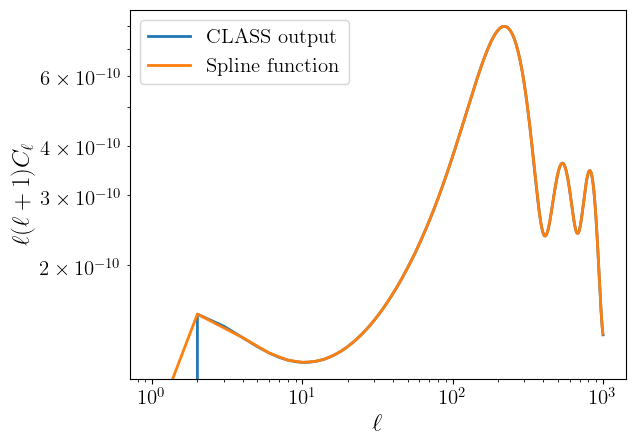

In [8]:
# Plot l*(l+1)*Cl/(2*pi)
plt.xlabel("$\ell$",size=18)
plt.ylabel("$\ell(\ell+1) C_\ell$",size=18)
plt.loglog(ell,Cl*(ell*(ell+1))/(2*np.pi),label='CLASS output')
plt.loglog(np.arange(0,999,2),Clfunc(np.arange(0,999,2))*(np.arange(0,999,2)*(np.arange(0,999,2)+1))/(2*np.pi)
           ,label='Spline function')
plt.legend(loc='best')
plt.savefig(dir+'CLASS_interpolation.pdf', dpi=300, bbox_inches="tight", transparent=True)
plt.savefig(dir+'CLASS_interpolation.png', dpi=300, bbox_inches="tight")
plt.show()

In [9]:
# Setup notations
nside=32
npix=hp.pixelfunc.nside2npix(nside)
lmax=min(len(Cl)-1, 3*nside-1)
nalm=hp.Alm.getsize(lmax)

Above $\mathrm{nside}=64$ the covariance matrix can't be stored...

## Setup signal covariance matrix

In [10]:
# Setup covariance matrix in harmonic space
covarFourier=np.zeros(nalm,dtype=complex)
for l in range(lmax+1):
    for m in range(lmax+1):
        idx=hp.Alm.getidx(lmax,l,m)
        covarFourier[idx]=Clfunc(l)

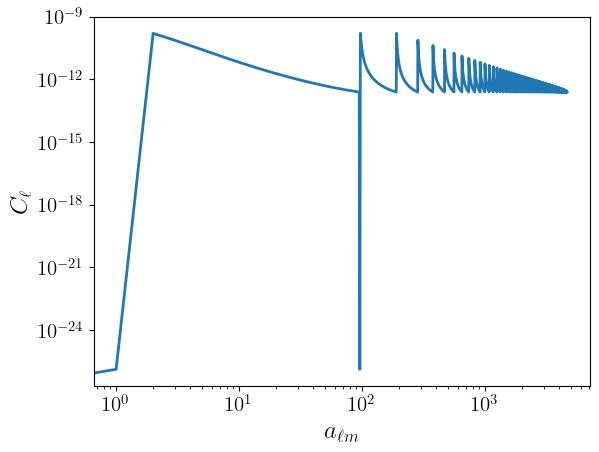

In [11]:
# Plot diagonal of the harmonic-space covariance matrix
plt.xlabel("$a_{\ell m}$",size=18)
plt.ylabel("$C_{\ell}$",size=18)
plt.loglog(np.arange(nalm),covarFourier.real)
plt.savefig(dir+'diagonal_harmonic_covariance_matrix.pdf', dpi=300, bbox_inches="tight", transparent=True)
plt.savefig(dir+'diagonal_harmonic_covariance_matrix.png', dpi=300, bbox_inches="tight")
plt.show()

Each row of the covariance matrix in pixel space is given by:
$C_i = \mathcal{F}^{-1} \left[ C_{a_{\ell m}a_{\ell m}}a_{\ell m}(i) \right]$
where
$a_{\ell m}(i) = \mathcal{F} \left[ e(i) \right]$.<br/>
$e(i) = [\delta^{i,j}]_{0 \leq j < N_\mathrm{pix}}^\mathrm{T}$ is the unit vector of the pixel space basis.<br/>
$\mathcal{F}$ and $\mathcal{F}^{-1}$ are transformations from harmonic space to pixel space:

\begin{align}
    m(n) & = & \sum_{\ell m} a_{\ell m} Y_{\ell m}(n)\\
    a_{\ell m} & = & \sum_n m(n) Y_{\ell m}^*(n).
\end{align}

In [12]:
%%capture
if os.path.isfile("data/sqrtsignalcovarPix.npy"):
    # Load precomputed sqrt covariance matrix in pixel space
    sqrtsignalcovarPix=np.load("data/sqrtsignalcovarPix.npy")
else:
    # Setup covariance matrix in pixel space
    covarFouriermat=np.diagflat(covarFourier)
    signalcovarPix=np.zeros((npix,npix))
    for i in xrange(npix):
        ei=np.zeros(npix)
        ei[i]=1.
        alm=hp.sphtfunc.map2alm(ei)
        Calm=covarFouriermat.dot(alm)
        signalcovarPix[i]=hp.sphtfunc.alm2map(Calm,nside)
    signalcovarPix=signalcovarPix.T
    sqrtsignalcovarPix=scipy.linalg.sqrtm(signalcovarPix)
    del covarFouriermat, signalcovarPix
    np.save("data/sqrtsignalcovarPix",signalcovarPix)

The signal covariance matrix is diagonal in harmonic space, but dense in pixel space...

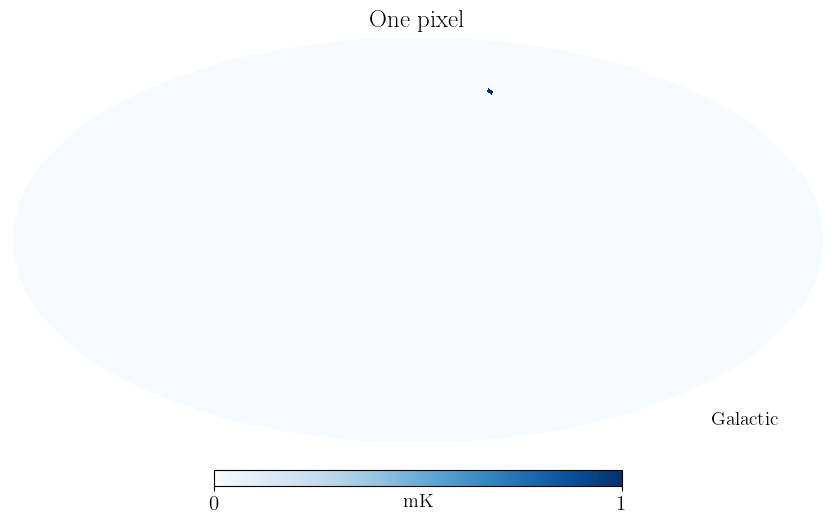

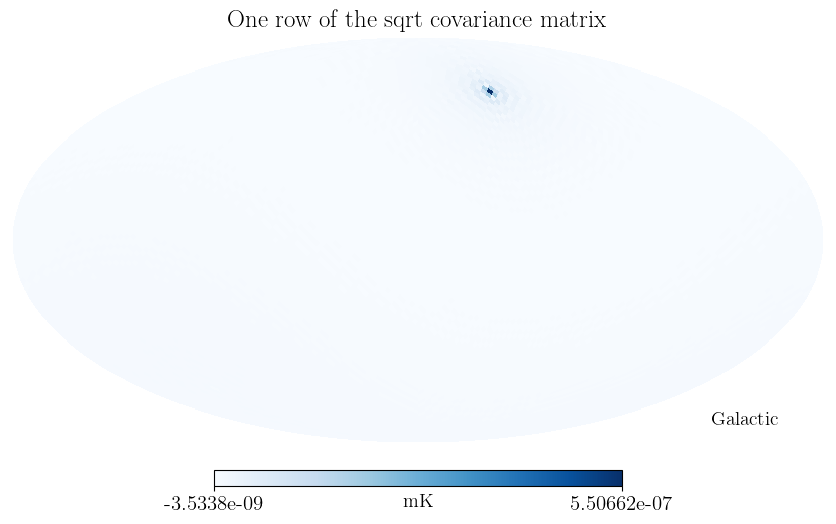

In [13]:
# Show sqrt covariance matrix in pixel space
i=1000
ei=np.zeros(npix)
ei[i]=1.
hp.mollview(ei, coord='G', title='One pixel', unit='mK',cmap="Blues")
plt.savefig(dir+'one_pixel.pdf', dpi=300, bbox_inches="tight", transparent=True)
plt.savefig(dir+'one_pixel.png', dpi=300, bbox_inches="tight")
hp.mollview(sqrtsignalcovarPix.real[i], coord='G', title='One row of the sqrt covariance matrix', unit='mK',cmap="Blues")
plt.savefig(dir+'one_row_sqrt_signal_covariance.pdf', dpi=300, bbox_inches="tight", transparent=True)
plt.savefig(dir+'one_row_sqrt_signal_covariance.png', dpi=300, bbox_inches="tight")
plt.show()

## Setup mask and noise covariance

In [14]:
%%capture
# Load the mask
fn = "data/TMASK_32_R2.01_full.fits"
tmask_map = hp.read_map(fn)
# Simplify to binary
tmask_map[np.where(tmask_map>0.)]=1.

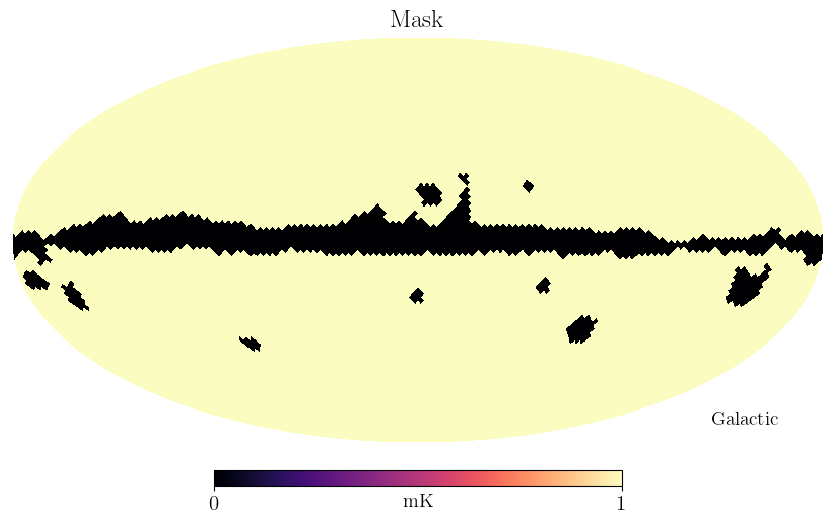

In [15]:
hp.mollview(tmask_map, coord='G', title='Mask', unit='mK', cmap="magma")
plt.savefig(dir+'mask.pdf', dpi=300, bbox_inches="tight", transparent=True)
plt.savefig(dir+'mask.png', dpi=300, bbox_inches="tight")
plt.show()

In [16]:
%%capture
if os.path.isfile("data/invnoisecovar.npy"):
    # Load precomputed inverse noise covariance matrix in pixel space
    invnoisecovar=np.load("data/invnoisecovar.npy")
else:
    # Setup the noise covariance (infinite in masked regions)
    noisepower=1e-12
    noisecovar=noisepower*tmask_map
    noisecovar[np.where(tmask_map==0.)]=10000.
    invnoisecovar=1./noisecovar
    np.save("data/invnoisecovar",invnoisecovar)

The noise covariance matrix is assumed diagonal in pixel space.

## Generate mock data

In [17]:
%%capture
# Generate the true CMB signal
signal_map, signal_alms = hp.synfast(Cl, nside, alm=True, lmax=lmax, new=True)

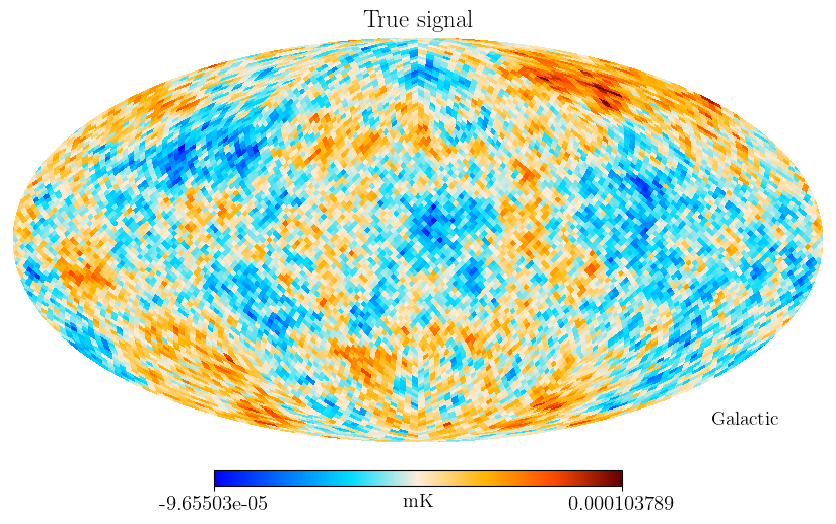

In [18]:
hp.mollview(signal_map, coord='G', title='True signal', unit='mK', cmap=planck)
plt.savefig(dir+'true_signal.pdf', dpi=300, bbox_inches="tight", transparent=True)
plt.savefig(dir+'true_signal.png', dpi=300, bbox_inches="tight")
plt.show()

Data model: $d=s+n$

In [19]:
# Generate simulated data
normalsim = np.random.normal(0., 1., len(signal_map))
noise_map = normalsim/np.sqrt(invnoisecovar+1e-12)
data_map = signal_map + noise_map
data_map_vis = hp.ma(data_map)
data_map_vis.mask = 1-tmask_map

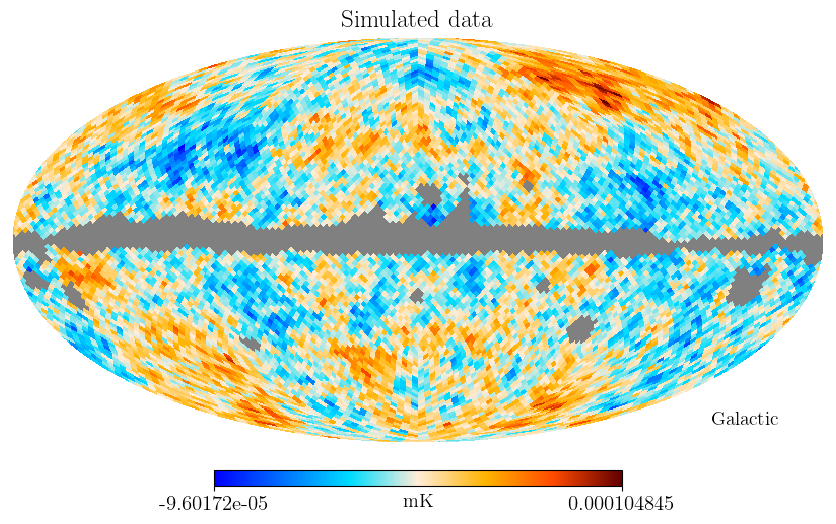

In [20]:
hp.mollview(data_map_vis, coord='G', title='Simulated data', unit='mK', cmap=planck)
plt.savefig(dir+'simulated_data.pdf', dpi=300, bbox_inches="tight", transparent=True)
plt.savefig(dir+'simulated_data.png', dpi=300, bbox_inches="tight")
plt.show()

## Setup Wiener filter

Covariance of the Wiener Filter:
\begin{equation}
\mathrm{Cov}_\mathrm{WF} = (N^{-1}+S^{-1})^{-1} = S^{1/2}(I+S^{1/2}N^{-1}S^{1/2})^{-1}S^{1/2}
\end{equation}
For applications we only need to keep in memory
$\mathrm{Cov}_\mathrm{WF}N^{-1}$ and $\sqrt{\mathrm{Cov}_\mathrm{WF}}$.

In [21]:
%%capture
if os.path.isfile("data/CovWFinvnoisecovarmat.npy") and os.path.isfile("data/sqrtCovWF.npy"):
    # Load precomputed covariance of the Wiener filter
    del sqrtsignalcovarPix
    CovWFinvnoisecovarmat=np.load("data/CovWFinvnoisecovarmat.npy")
    sqrtCovWF=np.load("data/sqrtCovWF.npy")
else:
    # Setup covariance of the Wiener filter
    invnoisecovarmat=np.diagflat(tmask_map*invnoisecovar)
    M=np.identity(npix)+sqrtsignalcovarPix.dot(invnoisecovarmat).dot(sqrtsignalcovarPix)
    CovWF=sqrtsignalcovarPix.dot(np.linalg.inv(M)).dot(sqrtsignalcovarPix)
    del sqrtsignalcovarPix, M
    # Setup CovWF*N^-1
    CovWFinvnoisecovarmat=CovWF.dot(invnoisecovarmat)
    np.save("data/CovWFinvnoisecovarmat",CovWFinvnoisecovarmat)
    # Setup sqrtCovWF for simulating signals
    CovWFsym=(CovWF+CovWF.T)/2
    del CovWF
    sqrtCovWF=scipy.linalg.sqrtm(CovWFsym)
    del CovWFsim
    np.save("data/sqrtCovWF",sqrtCovWF)

## Perform signal reconstruction (apply Wiener Filtering)

Mean of the Wiener posterior:
\begin{equation}
s_\mathrm{WF} = \mathrm{Cov}_\mathrm{WF} N^{-1} d
\end{equation}

In [22]:
# Wiener filtered map (posterior mean)
sWF=CovWFinvnoisecovarmat.dot(data_map).real

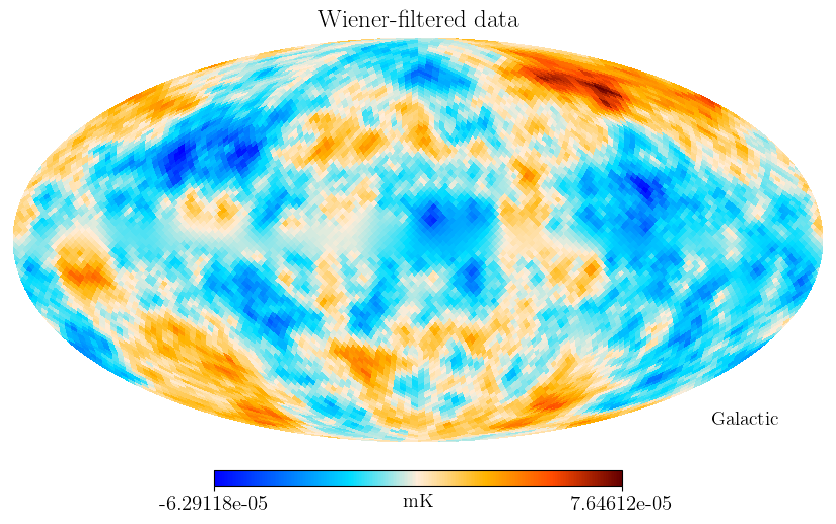

In [23]:
hp.mollview(sWF, coord='G', title='Wiener-filtered data', unit='mK', cmap=planck)
plt.savefig(dir+'reconstructed_signal.pdf', dpi=300, bbox_inches="tight", transparent=True)
plt.savefig(dir+'reconstructed_signal.png', dpi=300, bbox_inches="tight")
plt.show()

## Generate constrained realizations (draw samples from the Wiener posterior)

Samples of the Wiener posterior:
\begin{equation}
s=s_\mathrm{WF}+\sqrt{C_\mathrm{WF}} \, G(0,1)
\end{equation}
so that $\left\langle s \right\rangle = s_\mathrm{WF}$ and $\mathrm{Cov}(s) = C_\mathrm{WF}$

In [24]:
# Constrained realizations (samples of the Wiener posterior)
cr1=sqrtCovWF.dot(np.random.normal(0.,1.,npix)).real+sWF
cr2=sqrtCovWF.dot(np.random.normal(0.,1.,npix)).real+sWF
cr3=sqrtCovWF.dot(np.random.normal(0.,1.,npix)).real+sWF

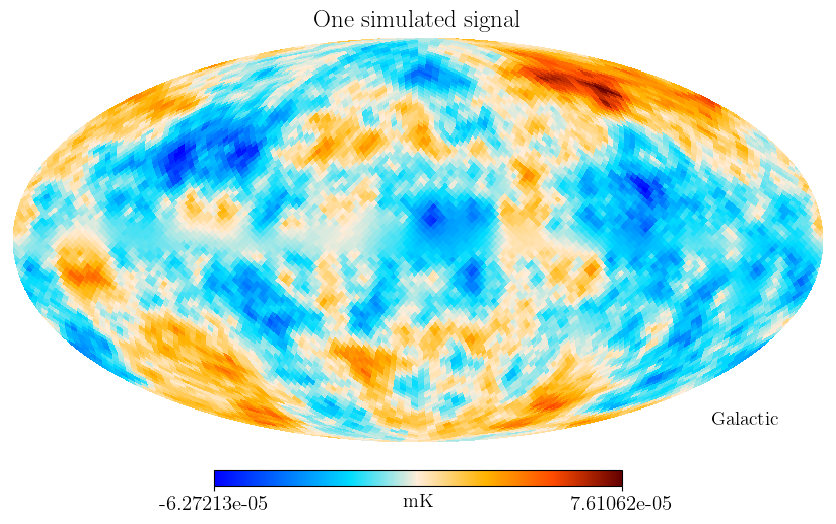

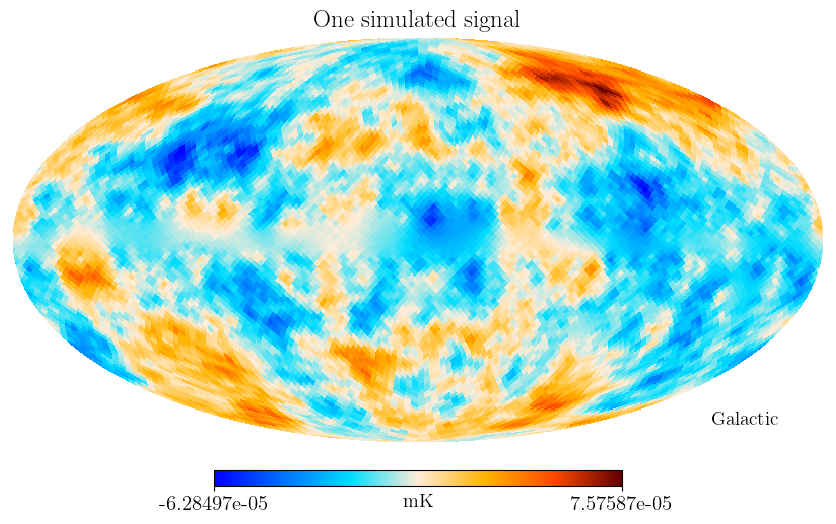

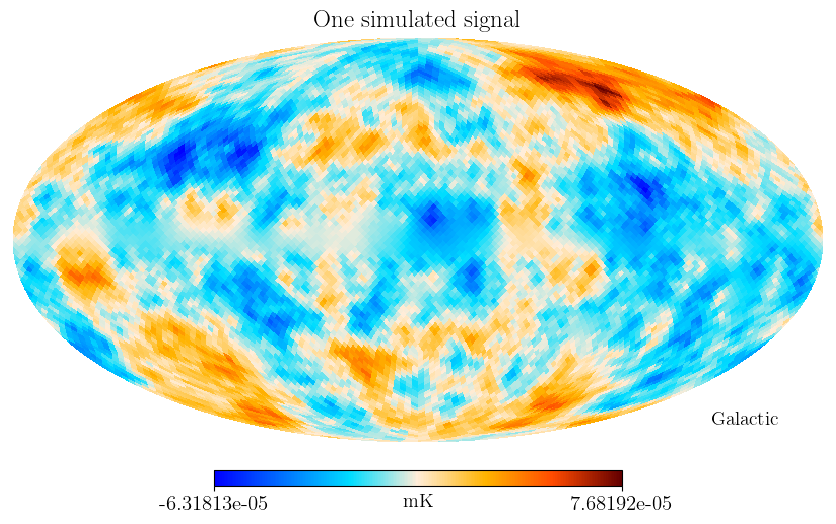

In [25]:
hp.mollview(cr1.real, coord='G', title='One simulated signal', unit='mK', cmap=planck)
plt.savefig(dir+'simulated_signal1.pdf', dpi=300, bbox_inches="tight", transparent=True)
plt.savefig(dir+'simulated_signal1.png', dpi=300, bbox_inches="tight")
plt.show()
hp.mollview(cr2.real, coord='G', title='One simulated signal', unit='mK', cmap=planck)
plt.savefig(dir+'simulated_signal2.pdf', dpi=300, bbox_inches="tight", transparent=True)
plt.savefig(dir+'simulated_signal2.png', dpi=300, bbox_inches="tight")
plt.show()
hp.mollview(cr3.real, coord='G', title='One simulated signal', unit='mK', cmap=planck)
plt.savefig(dir+'simulated_signal3.pdf', dpi=300, bbox_inches="tight", transparent=True)
plt.savefig(dir+'simulated_signal3.png', dpi=300, bbox_inches="tight")
plt.show()

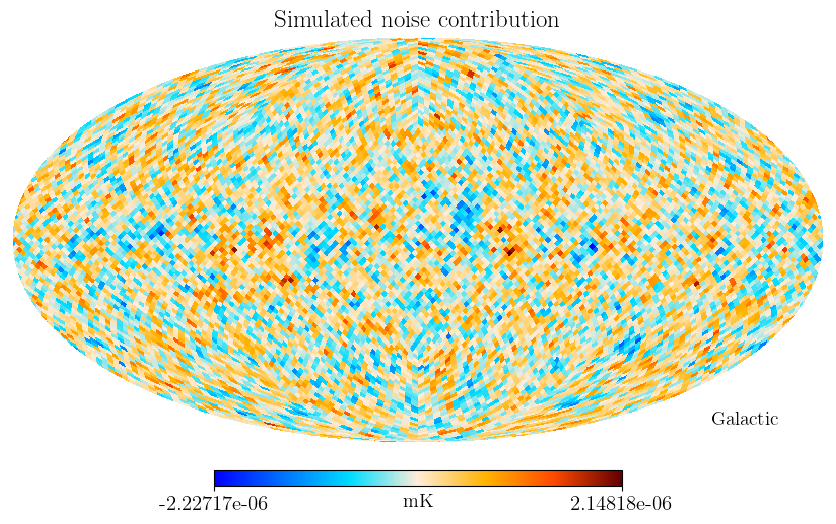

In [26]:
hp.mollview(cr1.real-sWF, coord='G', title='Simulated noise contribution', unit='mK', cmap=planck)
plt.savefig(dir+'simulated_noise1.pdf', dpi=300, bbox_inches="tight", transparent=True)
plt.savefig(dir+'simulated_noise1.png', dpi=300, bbox_inches="tight")
plt.show()

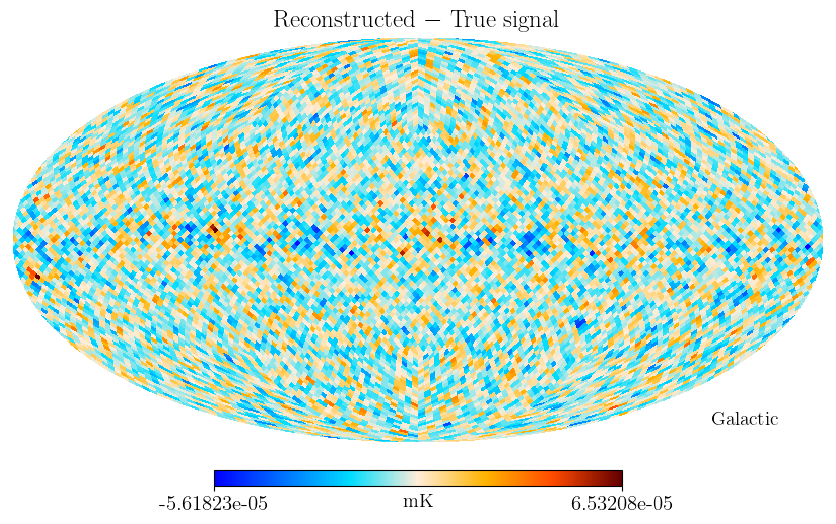

In [27]:
hp.mollview(cr1.real-signal_map, coord='G', title='Reconstructed $-$ True signal', unit='mK', cmap=planck)
plt.savefig(dir+'residuals1.pdf', dpi=300, bbox_inches="tight", transparent=True)
plt.savefig(dir+'residuals1.png', dpi=300, bbox_inches="tight")
plt.show()

Of course, this is a toy example. At higher resolution, it is impossible to deal with (invert, or even store) dense covariance matrices in either pixel or harmonic space. Techniques have been devised to perform Wiener filtering in such situations: (preconditioned) conjugate gradients and messenger-field approaches. They are beyond the scope of these lectures.